**Installing modules that are not preinstalled in colab**

In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


**Downloading Data**

In [ ]:
#downloading data
!git clone https://github.com/rslim087a/track

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163 (from 1)
Receiving objects: 100% (12163/12163), 156.98 MiB | 18.04 MiB/s, done.
Updating files: 100% (12160/12160), done.


**Importing Necessary Libraries**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import kerastuner as kt
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import random
import ntpath
from sklearn.utils import shuffle

<ipython-input-3-7056be32b2b9>:7: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


**Data Preprocessing**

In [ ]:
#Loading  and preprocessing the data
datadir = 'track'
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])

# Extracting filenames from paths using path_leaf function
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)


In [ ]:
# Update image paths to include the data directory
IMG_DIR = os.path.join(os.getcwd(), datadir, 'IMG')
data['center'] = data['center'].apply(lambda x: os.path.join(IMG_DIR, x.strip()))
data['left'] = data['left'].apply(lambda x: os.path.join(IMG_DIR, x.strip()))
data['right'] = data['right'].apply(lambda x: os.path.join(IMG_DIR, x.strip()))


In [ ]:
#removing redudandant data to prevent overfitting (in terms of steering angles)
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j + 1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

removed: 2790
remaining: 1263


In [ ]:
def augment_image_data(data):
    image_paths = []
    steering_angles = []

    correction = 0.15  # steering correction for left/right images

    for i in range(len(data)):
        center, left, right = data.iloc[i]['center'], data.iloc[i]['left'], data.iloc[i]['right']
        steering = data.iloc[i]['steering']

        # Add center image
        image_paths.append(center)
        steering_angles.append(steering)

        # Add left image with adjusted steering angle
        image_paths.append(left)
        steering_angles.append(steering + correction)

        # Add right image with adjusted steering angle
        image_paths.append(right)
        steering_angles.append(steering - correction)

    return np.array(image_paths), np.array(steering_angles)

image_paths, steering_angles = augment_image_data(data)

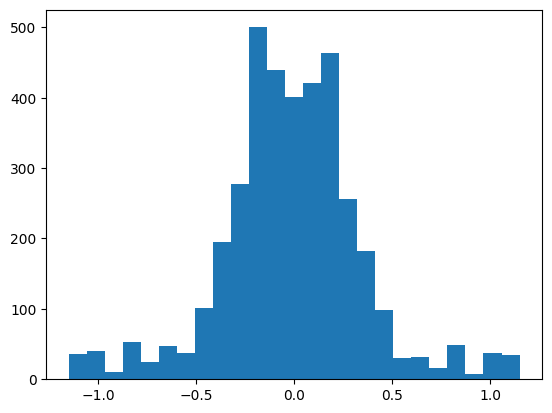

In [ ]:
import matplotlib.pyplot as plt
plt.hist(steering_angles, bins=25)
plt.show()

After removing excess data

In [ ]:
len(image_paths) , len(steering_angles)

(3789, 3789)

In [ ]:
#spliting data paths
X_train_paths, X_val_paths, y_train, y_val = train_test_split(image_paths, steering_angles, test_size=0.2, random_state=6)


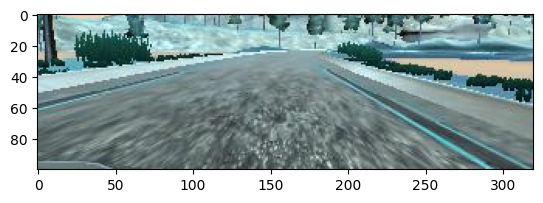

In [ ]:
from matplotlib.pyplot import imshow
imshow(X_train[3])

In [ ]:
#this function takes paths of images and output transformed images array
def load_images(image_paths):
    images = []
    for path in image_paths:
        # Fix the path by converting to a consistent format for Linux
        path = path.replace("\\", "/")
        path = os.path.normpath(path)

        image = cv2.imread(path)
        if image is None:  # Checking if image loading failed
            print(f"Error loading image: {path}")
            continue  # Skiping this image if loading failed

        image = image[60:140 , : , : ]
        image = image.astype('float32') / 255.0  # Resize to match autoencoder input shape
        images.append(image)
    return np.array(images)

#sperating images into train and validation sets
X_train = load_images(X_train_paths)
X_val = load_images(X_val_paths)

In [ ]:
#creating autoencoder model by using the shape of our data input

shape = X_train[0].shape
def create_autoencoder():
    input_img = keras.Input(shape)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
    encoded = layers.MaxPooling2D((4, 4), padding='same')(x)

    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((4, 4))(x)


    x = layers.Cropping2D(((0, 0), (0, 0)))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

Summary of the autoencoder model created

In [ ]:
autoencoder = create_autoencoder()
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 100, 320, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 100, 320, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 50, 160, 8)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 50, 160, 8)          │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 100, 320, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 100, 320, 3)         │             219 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,027 (4.01 KB)

 Trainable params: 1,027 (4.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder = create_autoencoder()
autoencoder.fit(X_train, X_train, epochs=10, batch_size=64, validation_data=(X_val, X_val))

# Integrate the encoder part of the autoencoder into the main model
encoder = keras.Model(autoencoder.input, autoencoder.layers[2].output)



Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - loss: 0.6876 - val_loss: 0.6705
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.6629 - val_loss: 0.6429
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.6384 - val_loss: 0.6310
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.6297 - val_loss: 0.6282
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.6278 - val_loss: 0.6271
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.6263 - val_loss: 0.6262
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.6254 - val_loss: 0.6256
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.6255 - val_loss: 0.6250
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.6241 - val_loss: 0.6245
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.6248 - val_loss: 0.6241


Code to save and download autoencoder model

In [ ]:

# autoencoder.save('autoencoder2.keras')
# from google.colab import files
# files.download('autoencoder2.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Preparing image data set for the final model**

In [ ]:
#transforming images using trained encoder
def preprocess_with_autoencoder(image):
    image = image[np.newaxis, ...]
    image = encoder.predict(image,verbose=0)
    return image

Visualizing the image output of the encoder

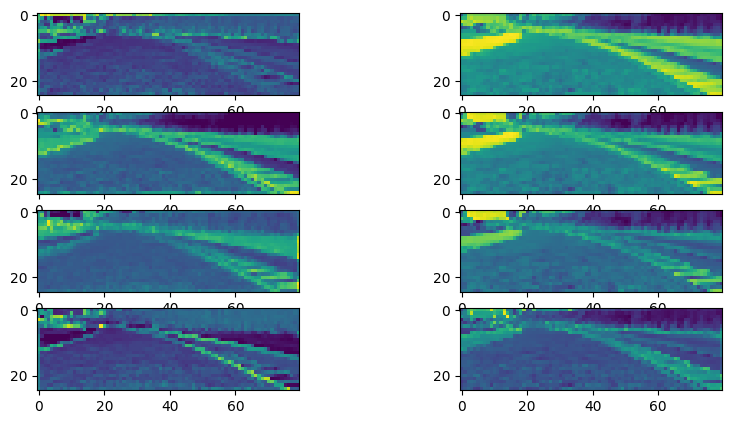

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(8):

  plt.subplot(8, 2, i + 1)
  imshow(preprocess_with_autoencoder(X_train[0])[0][:, :, i])
plt.show()

Shows the feature map learned that is to be given to the Final model

In [ ]:
train_images = np.array([preprocess_with_autoencoder(img) for img in X_train])
val_images = np.array([preprocess_with_autoencoder(img) for img in X_val])

In [ ]:
train_images = np.squeeze(train_images, axis=1)
val_images = np.squeeze(val_images, axis=1)

**Hyperparameter tunining**

In [ ]:
# Hyperparameter tuning function using KerasTuner
shape = train_images[0].shape
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(hp.Int('conv_1_filter', min_value=24, max_value=64, step=12),
                            (5, 5), activation='elu', strides=(2, 2), input_shape=shape))
    model.add(layers.Conv2D(hp.Int('conv_2_filter', min_value=36, max_value=128, step=24),
                            (5, 5), activation='elu', strides=(2, 2)))
    #model.add(layers.Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
    model.add(layers.Conv2D(48, (3, 3), activation='elu'))
    model.add(layers.Flatten())

    # Dense layers with hyperparameter tuning
    model.add(layers.Dense(hp.Int('dense_units', min_value=50, max_value=150, step=50), activation='elu'))
    model.add(layers.Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(layers.Dense(10, activation='elu'))
    model.add(layers.Dense(1))

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])),
                  loss='mse')
    return model

model.compile functions show the hyperparameters that we are going to try out. The hyperparameter is learining rate. And loss is fixed as mean square error

In [ ]:
tuner = kt.RandomSearch(build_model, objective='val_loss', max_trials=5, directory='tuning_dir')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Searching for best hyperparameters and training with optimal settings
tuner.search(train_images, y_train, epochs=10, validation_data=(val_images, y_val))

best_model = tuner.get_best_models(num_models=1)[0]
best_model.fit(train_images, y_train, epochs=10, validation_data=(val_images, y_val),verbose=0)

Trial 5 Complete [00h 00m 19s]
val_loss: 0.029355034232139587

Best val_loss So Far: 0.026277117431163788
Total elapsed time: 00h 01m 28s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Code to save the final model

In [ ]:
# best_model.save('my_model_autoencoder1.keras')
# from google.colab import files
# files.download('my_model_autoencoder1.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>